In [1]:
'''This block links the notebook to other folders.'''

import os
import sys


project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the system path for module imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# --- 2. Define Absolute Path for figs folder ---
figs_dir = os.path.join(project_root, 'figs')
data_dir = os.path.join(project_root, 'generated_data')

# Create the directory if it doesn't exist (good practice!)
os.makedirs(figs_dir, exist_ok=True) 

In [2]:
from src import Halos, SimSlab, BiasModel, ThetaModel, ModelComparison, SimCube
from src import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from mpmath import gammainc
from mpmath import erf
import plothist

In [3]:
def gammainc_vec(a, x):
    result = []
    for i in range(x.size):
        result.append(float(gammainc(a[i], x[i])))
        
    return np.array(result)

def erf_vec(x):
    result = []
    for i in range(x.size):
        result.append(float(erf(x[i])))
        
    return np.array(result)

In [4]:
dens_512 = fits.open("/Users/elyasfarah/Documents/Galaxy Bias/deltam.fits")
dens_512 = pd.DataFrame(dens_512[1].data)
ix_matter = dens_512["ix"]
iy_matter = dens_512["iy"]
iz_matter = dens_512["iz"]
dens = dens_512["dens"]
delta_m_grid = SimSlab.delta_m_catalogue_to_grid(ix_matter= ix_matter, iy_matter=iy_matter, 
                                              iz_matter=iz_matter, delta_m=dens, resol=512)

In [5]:
dens_512.columns

Index(['ix', 'iy', 'iz', 'dens'], dtype='object')

In [6]:
L      = 1000.

# Define the width of the slabs

slab_width = 125.

In [7]:
def rebin(a, N):
    sh = (N,a.shape[0]//N,
          N,a.shape[1]//N,
          N,a.shape[2]//N)

    b = a.reshape(sh)        
    return a.reshape(sh).mean(-1).mean(-2).mean(-3)

dens_256 = rebin(delta_m_grid, 256)
halo_df_filename = "/Users/elyasfarah/Documents/Galaxy Bias/halos.fits"

field_3d = SimCube(dens_256, L=L)
halos_256    = Halos(halo_df_filename, L, 256, MASS_CUTOFF_HIGH=10**13, MASS_CUTOFF_LOW=1e12)

Computing tidal fields...


In [8]:
# Extract eight 2d density slabs from the 3d density

delta_2d_list = field_3d.get_all_delta_slabs(slab_width)

In [9]:
del dens_256, delta_m_grid, dens_512

In [10]:
delta_2d_arr = np.array(delta_2d_list)
ncells = 8*4096
delta_m_vec = np.sort(delta_2d_arr.flatten())
delta_m_2D_bins = delta_m_vec.reshape(-1,ncells)

delta_m_bin_edges1 = np.zeros(delta_m_2D_bins.shape[0] + 1)
delta_m_bin_edges1[0] = np.min(delta_m_2D_bins, axis=1)[0]
delta_m_bin_edges1[-1] = np.max(delta_m_2D_bins, axis=1)[-1]
delta_m_bin_edges1[1:-1] = (np.max(delta_m_2D_bins, axis=1)[:-1] + np.min(delta_m_2D_bins, axis=1)[1:])/2

In [11]:
# splitting the last bin into more bins
ncells2 = 4*2048
delta_m_last_bin = delta_m_2D_bins[-1].reshape(-1, ncells2)
delta_m_bin_edges2 = np.zeros(delta_m_last_bin.shape[0] + 1)
delta_m_bin_edges2[0] = np.min(delta_m_last_bin, axis=1)[0]
delta_m_bin_edges2[-1] = np.max(delta_m_last_bin, axis=1)[-1]
delta_m_bin_edges2[1:-1] = (np.max(delta_m_last_bin, axis=1)[:-1] + np.min(delta_m_last_bin, axis=1)[1:])/2

In [12]:
delta_bins = np.concatenate([delta_m_bin_edges1[:-2], delta_m_bin_edges2])

In [13]:
M_range = '12_13'
mass_bins = np.logspace(12, 13,50)
mass_bin_centre = np.sqrt(mass_bins[1:] * mass_bins[:-1])

In [14]:
slab_id = (halos_256.z_halo // slab_width).astype(int)


In [15]:
nM_list = []

delta_mean_list = []
halos = halos_256
for i in range(len(delta_bins) - 1):
    delta_halo = delta_2d_arr[slab_id,halos.ix_halo, halos.iy_halo] #TAKING THE VOXELS THAT HAVE HALOS
    select_halo_delta = (delta_halo > delta_bins[i]) & (delta_halo < delta_bins[i+1]) # TAKING THE VOXELS IN A PARTICULAR DELTA_M BIN
    select_halo_mass  = halos.halo_mass[select_halo_delta] # MASKING OUT THE HALOS WHICH DO NOT EXIST IN THE CORRESPONDING DELTA_M BIN
    select_delta_bin = (delta_2d_arr > delta_bins[i]) & (delta_2d_arr < delta_bins[i+1]) # TAKING THE VOXELS IN A PARTICULAR DELTA_M BIN # MASKING OUT VOXELS OUTSIDE THE CHOSEN DELTA_M BIN
    delta_mean = delta_2d_arr[select_delta_bin].mean() # MASKING OUT VOXELS OUTSIDE THE CHOSEN DELTA_M BIN # THE MEAN DELTA_M OF THE SELECTED VOXELS
    delta_mean_list.append(delta_mean)
    
    N_pix = select_delta_bin.sum() # FIND THE NUMBER OF PIXELS IN THAT PARTICULr mass bin
    nV = select_halo_delta.sum() / N_pix # FIND THE AVERAGE NUMBER OF HALOS IN A VOXEL 
    
    pM, _ = np.histogram(select_halo_mass, mass_bins, density=True) # FIND THE WEIGHTED DISTRIBUTION OF HALO MASS IN EACH BIN
    nM_list.append(pM * nV) # FIND THE FRACTION OF HALOS IN EACH MASS BIN

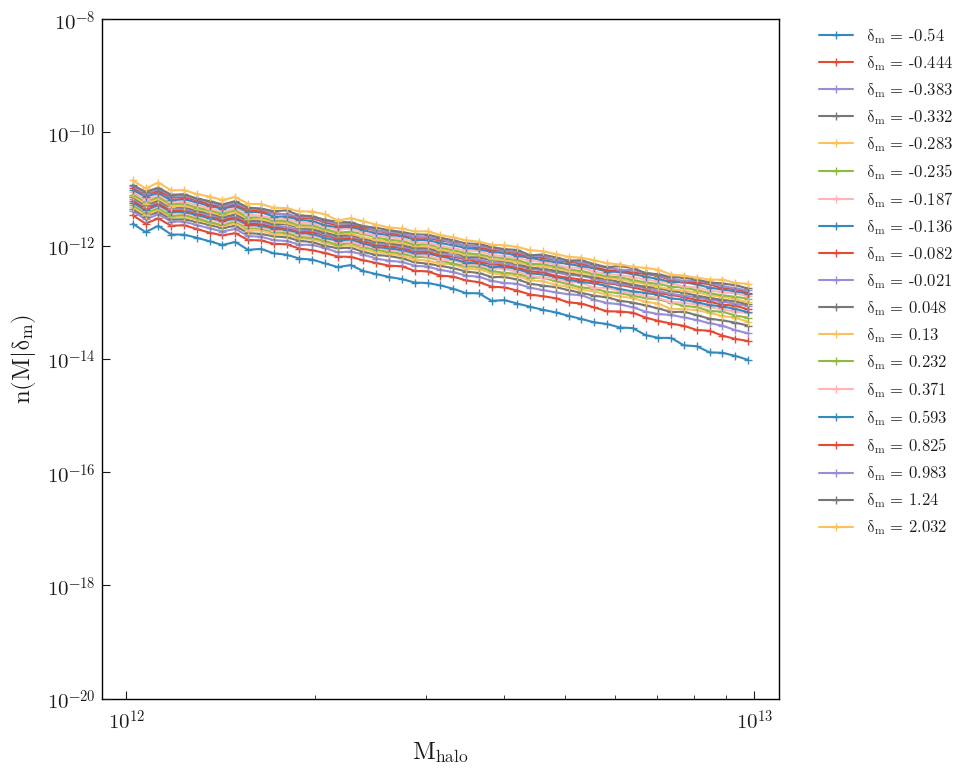

In [16]:
fig, ax = plt.subplots(figsize = (10, 8))
plt.ylim(1e-20, 1e-8)
for i in range(len(nM_list)):
   
    plt.plot(mass_bin_centre, nM_list[i],  marker = '+', label = rf'$\delta_m$ = {np.round(delta_mean_list[i], 3)}')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$M_{halo}$")
plt.ylabel(r"$n(M|\delta_{m})$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

fig.savefig(f'{figs_dir}/n_M_delta_{range}.png', dpi = 300)

In [17]:
class Bounds:
    '''A class that helps controling the bouds of a cube in parameter space. 
    It slides the bounds of the parameter space according to the output of the differential
    evolution optimization.'''
    def __init__(self, ns, alpha, M0, beta):
        self.log10_ns = ns
        self.alpha = alpha
        self.log10_M0 = M0
        self.beta = beta
        
    def get_bounds(self):
        return [self.log10_ns, self.alpha, self.log10_M0,  self.beta]
    
    def change_bounds_to_params(self, parameters):
        another_round = False
        for i in range(parameters.size):
            param_name = list(vars(self).keys())[i]
            
            param_bound =  vars(self)[param_name]
            
            if parameters[i] <= param_bound[0]:
                
                if param_name == "beta":
                    new_bounds = (param_bound[0] - 0.20, param_bound[1] - 0.20)
                elif param_name == "alpha":
                    new_bounds = (param_bound[0] - 0.20, param_bound[1] - 0.20)     
                else:
                    new_bounds = (param_bound[0] - 1.0, param_bound[1] - 1.0)
                setattr(self, param_name, new_bounds)
                another_round = True
            elif parameters[i] >= param_bound[1]:
                if param_name == 'beta':
                    new_bounds = (param_bound[0] + 0.20, param_bound[1] + 0.20)
                elif param_name == 'alpha':
                    new_bounds = (param_bound[0] + 0.20, param_bound[1] + 0.20)    
                else:
                    new_bounds = (param_bound[0] + 1.0, param_bound[1] + 1.0)
                setattr(self, param_name, new_bounds)
                another_round = True
        return another_round
    
    def get_lower_bounds(self):
        bounds = self.get_bounds()
        lower_bounds = np.min(bounds, axis = 1) + 0.05
        return  lower_bounds

In [18]:
bounds = Bounds((-17.3, -16.3),  (-1.9, -1.6),  (15., 16.),  (2.8, 3.2))

In [19]:
parameters = []
parameters_errors = []
method = 'Small Range'

In [24]:
objective_function((1,2,3,4))

TypeError: minus_Likelihood() got multiple values for argument 'fix_beta'

In [25]:
help(minus_Likelihood)

Help on function minus_Likelihood in module src.schechter_func:

minus_Likelihood(delta_2d_arr, halo_cat, delta_m_min, delta_m_max, log10_Mmin, log10_Mmax, fix_beta, slab_width=125, *params)
    Poissonian likelihood



In [36]:
from scipy.optimize import differential_evolution

if method == 'Full Range':
    for i in range(len(delta_mean_list)):
        round = 1
        index = len(delta_mean_list) - i -1
        while True:
            print('round', round, 'for bin', index)
            objective_function = lambda params: minus_Likelihood(delta_2d_arr, halos_256, delta_bins[index], delta_bins[index + 1], 12, 13, False, 125, *params)
            print(bounds.get_bounds(), bounds.get_lower_bounds())
            res = differential_evolution(objective_function, bounds = bounds.get_bounds(), x0 = bounds.get_lower_bounds() , seed = 42, maxiter=2500)
            change_bounds = bounds.change_bounds_to_params(res.x)
            if change_bounds:
                round = round + 1
                
            else:
                parameters.append(res.x)
                parameters_errors.append(res.population)
                print('bin', index, 'is completed within', round, 'rounds')
                print('===========')
                break
else:
    for i in range(delta_bins.size - 1):
        objective_function = lambda params: minus_Likelihood(delta_2d_arr, halos_256, delta_bins[i], delta_bins[i + 1], 12, 13, True, 125, *params)
        
        from scipy.optimize import minimize
        res = minimize(objective_function, x0 = (-14.7, -1.75, 14.1, 1), method =  "L-BFGS-B" )
        
        print('bin', i, method, res.x)
        parameters.append( res.x)
        parameters_errors.append(res.hess_inv(res.x))

bin 0 Small Range [-13.47108311  -2.00549678  12.94815374   1.        ]
bin 1 Small Range [-14.92188805  -2.10426026  13.64954478   1.        ]
bin 2 Small Range [-14.88860077  -2.03970307  13.71532492   1.        ]
bin 3 Small Range [-14.8659085   -1.99229217  13.765992     1.        ]
bin 4 Small Range [-14.84632161  -1.95648029  13.80536289   1.        ]
bin 5 Small Range [-14.82942645  -1.92483534  13.83911383   1.        ]
bin 6 Small Range [-14.80743489  -1.91423375  13.8547532    1.        ]
bin 7 Small Range [-14.80301782  -1.88782729  13.88866819   1.        ]
bin 8 Small Range [-14.79367318  -1.87004419  13.91534141   1.        ]
bin 9 Small Range [-14.7857306   -1.85987321  13.93617628   1.        ]
bin 10 Small Range [-14.77847736  -1.84918503  13.95595791   1.        ]
bin 11 Small Range [-14.76744473  -1.8319089   13.98133418   1.        ]
bin 12 Small Range [-14.75406962  -1.82411466  13.99828487   1.        ]
bin 13 Small Range [-14.74143115  -1.81658511  14.01968201   

In [37]:
color_list = ['r', 'b', 'g', 'c', 'm', 'orange', 'k', 'r', 'b', 'g', 'c', 'k', 'r', 'b', 'g', 'c','m', 'orange', 'k', 'r', 'b', 'r', 'b', 'g', 'c', 'm', 'orange', 'k', 'r', 'b', 'g', 'c', 'k', 'r', 'b', 'g', 'c','m', 'orange', 'k', 'r', 'b', 'r', 'b', 'g', 'c', 'm', 'orange', 'k', 'r', 'b', 'g', 'c', 'k', 'r', 'b', 'g', 'c','m', 'orange', 'k', 'r', 'b', 'r', 'b', 'g', 'c', 'm', 'orange', 'k', 'r', 'b', 'g', 'c', 'k', 'r', 'b', 'g', 'c','m', 'orange', 'k', 'r', 'b']

In [38]:
import plothist

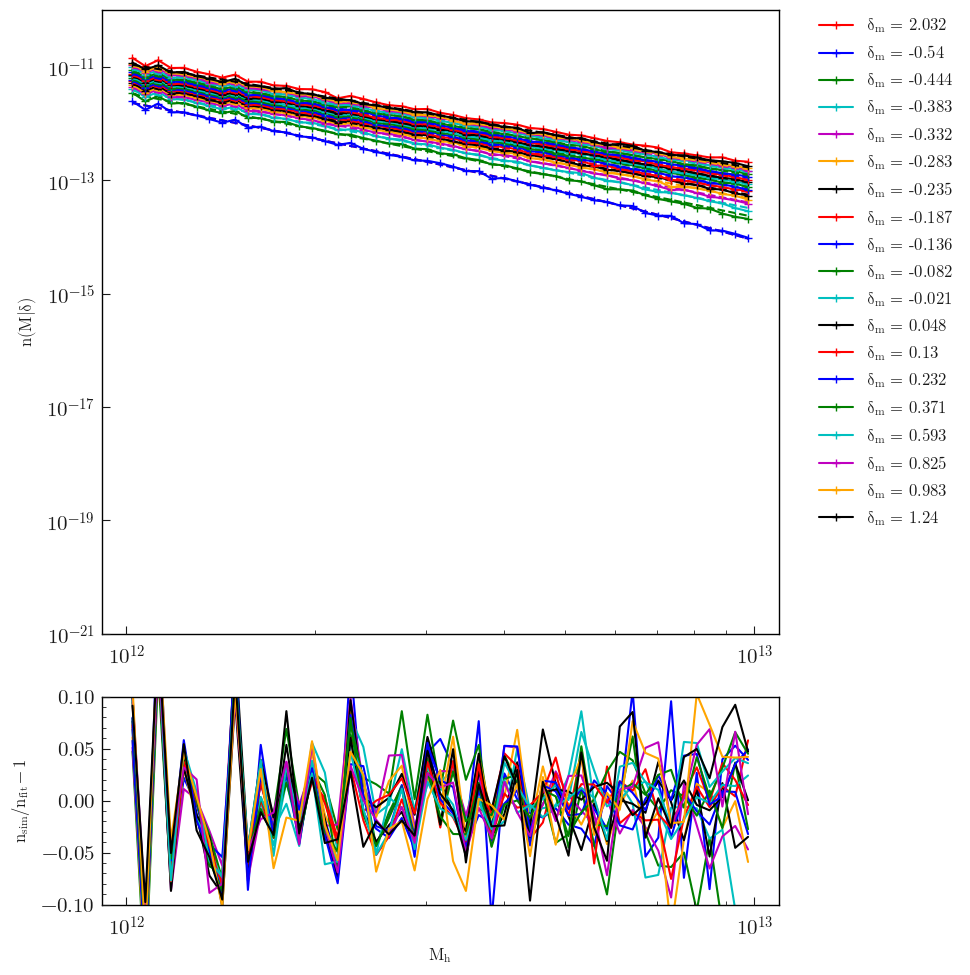

In [40]:
fig, (ax, ax_err) = plt.subplots(2, 1,gridspec_kw={'height_ratios': [3, 1]},figsize = (10, 10))
for i in range(len(delta_mean_list)):
    
    index = i - 1
    # if index != 0 and index != 5 and index != 15 and index != 18:
    #     continue
    log10_ns, alpha, log10_M0,  beta  = parameters[i]

    ax.loglog(mass_bin_centre, nM_list[index], color = color_list[i], marker = "+", label = rf'$\delta_m$ = {np.round(delta_mean_list[index], 3)}')
    nM_schechter= schechter_function(M = mass_bin_centre, log10_M0=log10_M0 , log10_ns=log10_ns, alpha=alpha, beta=beta)
    # ax.loglog(mass_bin_centre, term1, color='b')
    # ax.loglog(mass_bin_centre, term2, '-.', color='b')
    ax.loglog(mass_bin_centre, nM_schechter, '--', color = color_list[i] )
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    # nM_schechter_lower = schechter_function(mass_bin_centre, *parameters_lower[i], with_terms=False)
    # nM_schechter_higher = schechter_function(mass_bin_centre, *parameters_higher[i], with_terms=False)
    # ax.fill_between(mass_bin_centre, nM_schechter_lower, nM_schechter_higher, color = color_list[i], alpha = 0.2)
    ax.set_ylim(1e-21, 1e-10)
    ax_err.plot(mass_bin_centre, (nM_list[index]/nM_schechter) -1, color = color_list[i])
    ax_err.set_xscale('log')
    ax_err.set_ylim(-0.1, 0.1)
    ax.set_ylabel(r'$n(M|\delta)$',fontsize = 12)
    ax_err.set_xlabel(r'$M_h$', fontsize = 12)
    ax_err.set_ylabel(r'$n_{sim}/n_{fit} - 1$', fontsize = 12)
# ax.set_xlim(1e12, 1e14)
plt.tight_layout()
fig.savefig(f'{figs_dir}/sch_{M_range}.png', dpi = 300)

In [61]:
parameters = np.array(parameters)
parameters = np.flip(parameters, axis = 0)
parameters_errors = np.array(parameters_errors)
parameters_errors = np.flip(parameters_errors, axis = 0)

In [62]:
np.save(rf'{data_dir}/parameters_diff_evol_{M_range}.npy', np.array(parameters))
np.save(rf'{data_dir}/parameters_diff_evol_{M_range}.npy', np.array(parameters_errors))

In [68]:
log_delta_m = np.log(1 + np.array(delta_mean_list))
w = np.ones_like(log_delta)
w[-4:] = 0.25

In [69]:
from scipy.interpolate import UnivariateSpline

log10ns_interp = UnivariateSpline(y =parameters[:, 0], x = log_delta, k = 1, s = 2, ext = 0, w = w)


log10M0_interp = UnivariateSpline(y =parameters[:, 2], x = log_delta, k = 1, s = 1, ext = 0, w = w)


alpha_interp = UnivariateSpline(y = parameters[:, 1], x = log_delta, k = 1, s = 1, ext = 0, w = w)



beta_interp = UnivariateSpline(y =parameters[:, 3], x = log_delta, k = 1, s = 1, ext = 0, w = w)



In [72]:
parameters

array([[-17.11760246,  -2.32106462,  14.3808656 ,   2.96494401],
       [-16.97784801,  -2.16853994,  14.5468948 ,   3.06347295],
       [-16.43905338,  -2.09611517,  14.40735955,   3.10012053],
       [-17.25932378,  -2.04295781,  14.89246119,   3.04424302],
       [-16.70268553,  -2.00323304,  14.68878845,   3.01150317],
       [-16.605051  ,  -1.96848443,  14.69936255,   2.97062879],
       [-16.43690515,  -1.95659212,  14.64648139,   3.01967364],
       [-17.02807988,  -1.9271833 ,  15.00382481,   2.97604051],
       [-17.26894486,  -1.90735146,  15.17488023,   2.9855646 ],
       [-17.17317094,  -1.89557627,  15.15849252,   3.15968523],
       [-17.22341194,  -1.88730682,  15.21196607,   3.12232806],
       [-17.10764336,  -1.86429234,  15.20158829,   3.07555861],
       [-17.19773948,  -1.85541615,  15.28106496,   3.04335106],
       [-16.91277842,  -1.84648552,  15.1624006 ,   3.1082071 ],
       [-16.86589061,  -1.84157947,  15.16843271,   3.06863482],
       [-16.9337638 ,  -1

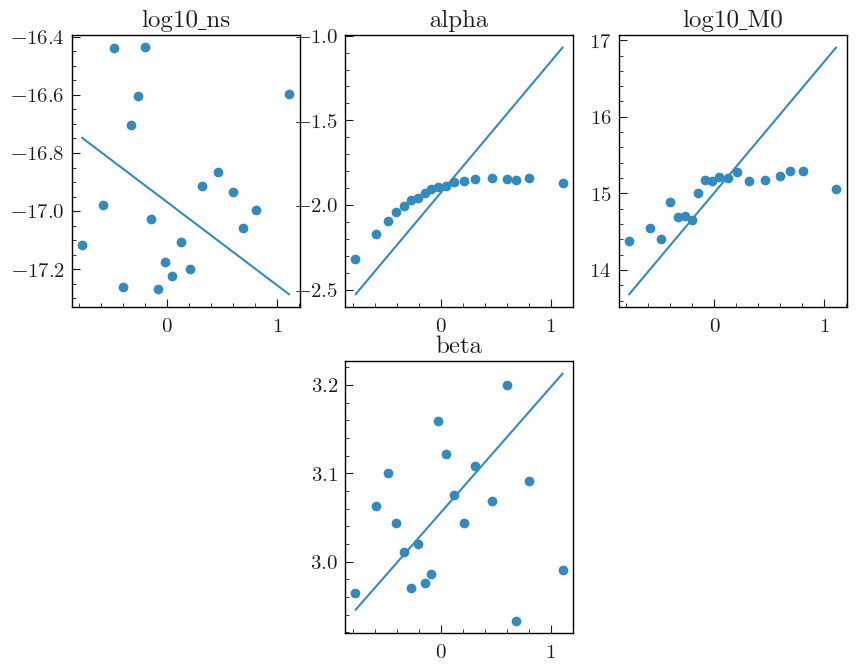

In [71]:
x = np.linspace(-1, 5)




fig = plt.figure(figsize=(10, 12))


ax1 = plt.subplot2grid((3, 3), (0, 0))
ax2 = plt.subplot2grid((3, 3), (0, 1))
ax3 = plt.subplot2grid((3, 3), (0, 2))


ax4 = plt.subplot2grid((3, 3), (1, 1), colspan=1)











ax1.set_title('log10_ns')
ax1.scatter(log_delta_m, parameters[:, 0])
ax1.plot(log_delta_m, log10ns_interp(log_delta_m))

ax2.set_title('alpha')
ax2.scatter(log_delta_m, parameters[:, 1])
ax2.plot(log_delta_m, alpha_interp(log_delta_m))



ax3.set_title('log10_M0')
ax3.scatter(log_delta_m, parameters[:, 2])
ax3.plot(log_delta_m,log10M0_interp(log_delta_m))


ax4.set_title('beta')
ax4.scatter(log_delta_m, parameters[:, 3])
ax4.plot(log_delta_m, beta_interp(log_delta_m))



fig.savefig(rf'{figs_dir}/parameters_{M_range}.png', dpi = 300)

In [152]:
M_min = 10**12
M_max = 10**15


M_halo_bin_edges = np.logspace(np.log10(M_min), np.log10(M_max), 6)

In [153]:
nh_list = []
delta_m = np.log10(1 + np.linspace(-0.9, 2.5, 100))
log_M_bin_edges = np.log10(M_halo_bin_edges)

In [154]:
def nh(log10_one_delta_m, log10_Mmin, log10_Mmax, *funcs):
    log10_ns_func, alpha_func, log10_M0_func, beta_func = funcs
    
    log10_ns = log10_ns_func(log10_one_delta_m)
    alpha = alpha_func(log10_one_delta_m)
    log10_M0 = log10_M0_func(log10_one_delta_m)
    beta = beta_func(log10_one_delta_m)
    
    log10_min = log10_Mmin - log10_M0
    log10_max = log10_Mmax - log10_M0
    
    Gamma_min = gammainc_vec((alpha + 1)/beta, (10**log10_min)**beta)
    Gamma_max = gammainc_vec((alpha + 1)/beta, (10**log10_max)**beta)
    term1 = (10**log10_ns)*(10**log10_M0)*(1/beta)* (Gamma_min - Gamma_max)
    
    
    
   
    return term1

In [155]:
term1_list = []
term2_list = []

for i in range(log_M_bin_edges.size - 1): 
    value = nh(log_delta_m, log_M_bin_edges[i], log_M_bin_edges[i + 1], log10ns_interp, alpha_interp, log10M0_interp, beta_interp)
    nh_list.append(value)
    


Text(0, 0.5, '$n(\\delta_{m}^{2D}|M_h))$')

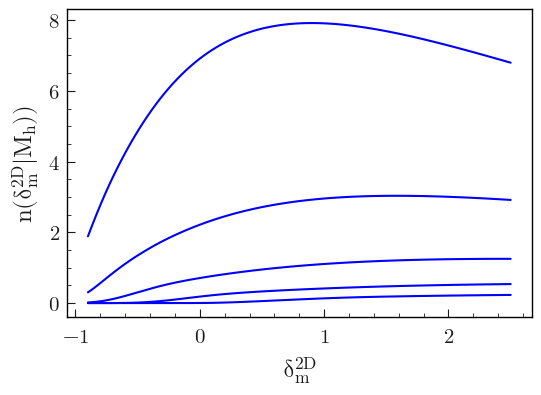

In [165]:
for i in range(log_M_bin_edges.size - 1):
    plt.plot(np.linspace(-0.9, 2.5, 100), nh_list[i], color = 'b')

plt.xlabel(r'$\delta_{m}^{2D}$')
plt.ylabel(r'$n(\delta_{m}^{2D}|M_h))$')
# plt.yscale("log")


In [163]:
np.save("/Users/elyasfarah/Documents/Galaxy Bias/lib/nh_list_12_16.npy", nh_list)